In [1]:
import os
from time import sleep
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import cv2

import matplotlib
from scipy import optimize

matplotlib.rc('figure', figsize=(15, 10))

In [2]:
base_dir = "D:\\Data\\Dispertech\\2020-11-09"
list_files = []
print('These are the available files:')
for root, dirs, files in os.walk(base_dir):
    for file in files:
        if file.endswith('.npy'):
            print(len(list_files), file)
            list_files.append(file)

These are the available files:
0 fiber_end_2001001_0.npy
1 fiber_end_2001001_1.npy
2 fiber_end_2001001_2.npy
3 fiber_end_2001001_3.npy
4 fiber_end_2001002_0.npy
5 fiber_end_2001002_1.npy
6 fiber_end_2001003_0.npy
7 fiber_end_2001003_1.npy
8 fiber_end_2001004_0.npy
9 fiber_end_2001005_0.npy
10 microscope_2001001_0.npy
11 microscope_2001001_1.npy
12 microscope_2001001_2.npy
13 microscope_2001001_3.npy
14 microscope_2001001_4.npy
15 microscope_2001002_0.npy
16 microscope_2001003_0.npy
17 microscope_2001003_1.npy
18 microscope_2001004_0.npy
19 microscope_2001004_1.npy
20 microscope_2001005_0.npy
21 microscope_2001005_1.npy


In [3]:
file_to_analyze = 1

In [4]:
def gaussian(height, center_x, center_y, width_x, width_y):
    """Returns a gaussian function with the given parameters"""
    width_x = float(width_x)
    width_y = float(width_y)
    return lambda x,y: height*np.exp(
                -(((center_x-x)/width_x)**2+((center_y-y)/width_y)**2)/2)

def moments(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution by calculating its
    moments """
    total = data.sum()
    X, Y = np.indices(data.shape)
    x = (X*data).sum()/total
    y = (Y*data).sum()/total
    col = data[:, int(y)]
    width_x = np.sqrt(np.abs((np.arange(col.size)-y)**2*col).sum()/col.sum())
    row = data[int(x), :]
    width_y = np.sqrt(np.abs((np.arange(row.size)-x)**2*row).sum()/row.sum())
    height = data.max()
    return height, x, y, width_x, width_y

def fitgaussian(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution found by a fit"""
    params = moments(data)
    errorfunction = lambda p: np.ravel(gaussian(*p)(*np.indices(data.shape)) -
                                 data)
    p, success = optimize.leastsq(errorfunction, params)
    return p

def plot_fiber_end(data, x=None, y=None, crop_size=15):
    if x is None:
        x = 500
    if y is None:
        y = 500

    fig, ax = plt.subplots(1, 2, figsize=(18,10), dpi=100)
    fig.set()
    ax[0].imshow(data.T)
    ax[0].axhline(y=y,color='red')
    ax[0].axvline(x=x,color='red')

    cropped_data = np.copy(data[x-crop_size:x+crop_size, y-crop_size:y+crop_size])
    cropped_data[cropped_data<np.mean(cropped_data)+np.std(cropped_data)] = 0
    p = fitgaussian(cropped_data)
    extracted_position = p[1]+x-crop_size, p[2]+y-crop_size
    print(x, y)
    print(extracted_position)
    ax[1].imshow(cropped_data)
    ax[1].axhline(y=p[1],color='red')
    ax[1].axvline(x=p[2],color='red')
    valid = False
    if np.sqrt((x-extracted_position[0])**2 + (y-extracted_position[1])**2) < 1:
        valid = True
    return extracted_position, valid

def plot_laser_position(data, make_plot=False):
    mask = data>np.mean(data.reshape(data.size,1))+np.std(data.reshape(data.size,1))
    M = cv2.moments(mask*data)
    cx = M['m10']/M['m00']
    cy = M["m01"] / M["m00"]
    print(cx, cy)
    if make_plot:
        fig, ax = plt.subplots(1, figsize=(11,10), dpi=100)
        fig.set()
        ax.imshow(mask.T)
        ax.axhline(y=cx,color='red')
        ax.axvline(x=cy,color='red')
    return (cy, cx) # The image is transposed compared to what we expect

740 500
(739.8205440808431, 502.00055906609873)


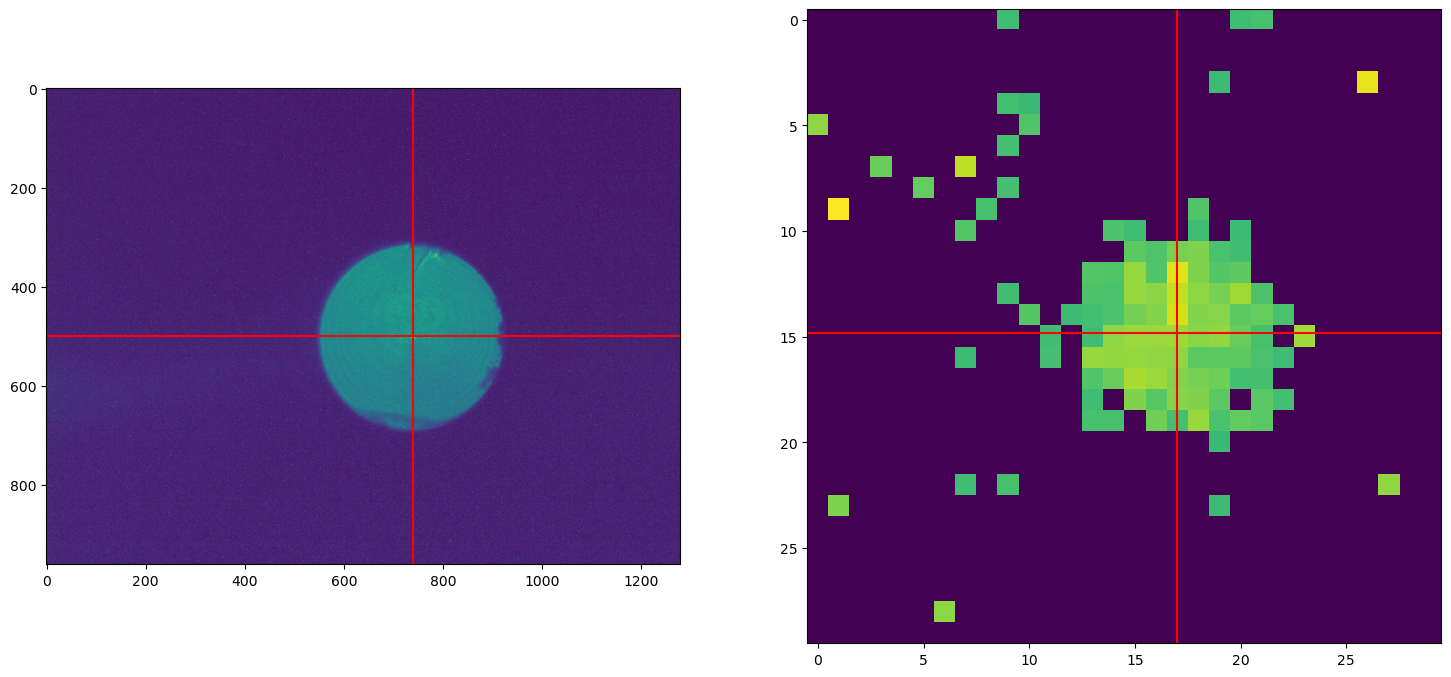

In [5]:
fiber_end = list_files[file_to_analyze]
data = np.load(os.path.join(base_dir, fiber_end))
center, valid = plot_fiber_end(data, 740, 500)
# if valid:
#     print('Saving data')
#     filename = 'coordinates_' + fiber_end
    
#     np.save(os.path.join(base_dir, filename), center)

496.0810309690362 729.1152616138156


(729.1152616138156, 496.0810309690362)

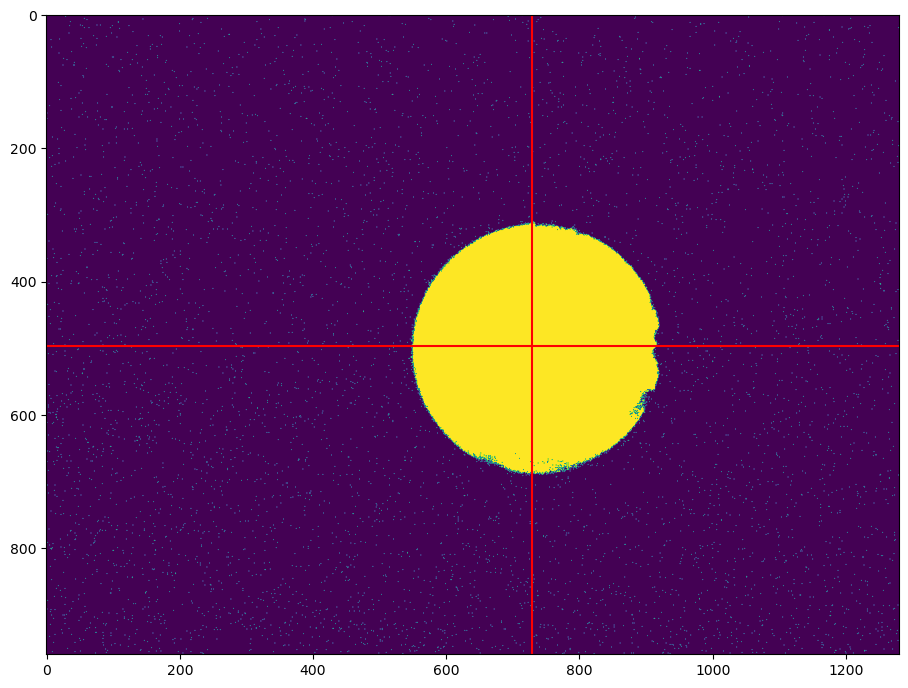

In [6]:
plot_laser_position(data, True)

In [7]:
mask = data>np.mean(data.reshape(data.size,1))+np.std(data.reshape(data.size,1))

In [71]:
img_16 = data*2**16/np.max(data)
img_8 = (img_16/256).astype('uint8')

In [232]:
img = np.copy(img_8)

ret, thresh = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
thresh = cv2.bitwise_not(thresh)
element = cv2.getStructuringElement(shape=cv2.MORPH_ELLIPSE, ksize=(5, 5))
morph_img = thresh.copy()
out = cv2.morphologyEx(src=thresh, op=cv2.MORPH_CLOSE, kernel=element, dst=morph_img)

ret, thresh = cv2.threshold(out,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
thresh = cv2.bitwise_not(thresh)

In [233]:
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [234]:
len(contours)

37

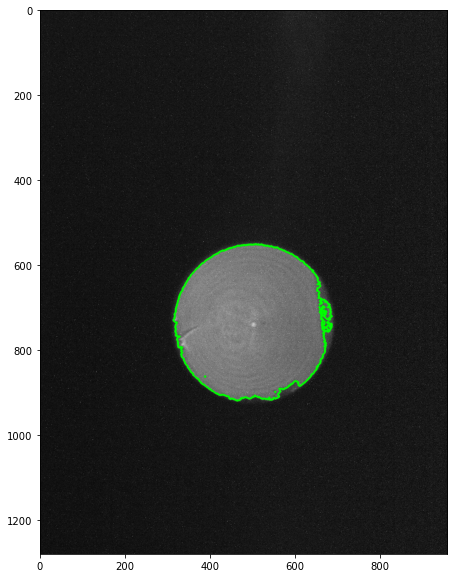

In [259]:
test_img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
cv2.drawContours(test_img, contours[:], -1, (0,255,0), 3)
plt.imshow(test_img, cmap='gray')

In [268]:
areas = [cv2.contourArea(c) for c in contours]
sorted_areas = np.sort(areas)
cnt=contours[areas.index(sorted_areas[-1])] #the biggest contour
r = cv2.boundingRect(cnt)

#min circle 
(x,y),radius = cv2.minEnclosingCircle(cnt)
center = (x,y)
radius = int(radius)
print(center)

(501.2721862792969, 735.876220703125)


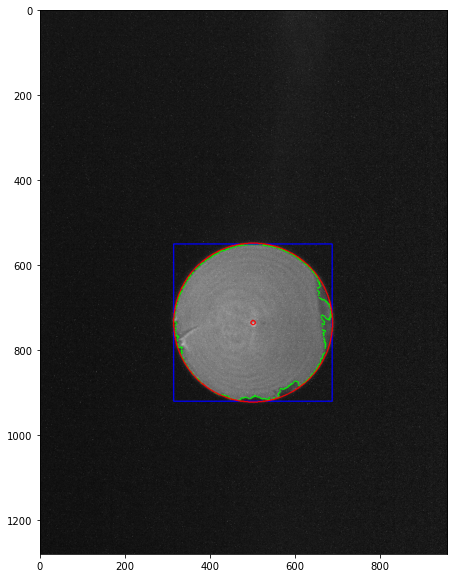

In [277]:
fig = plt.figure()
test_img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
cv2.drawContours(test_img, cnt, -1, (0,255,0), 2)
rect = cv2.rectangle(test_img,(r[0],r[1]),(r[0]+r[2],r[1]+r[3]),(0,0,255),2)
circle = cv2.circle(test_img, (int(x), int(y)), radius, (255, 0, 0), 2)
circle = cv2.circle(test_img, (int(x), int(y)), 5, (255, 0, 0), 2)
plt.imshow(test_img, cmap='gray')
fig.set_xlim = (r[0], r[0]+r[2])

In [278]:
(r[0], r[0]+r[2])

(314, 687)

103932.0

In [221]:
print(center, radius)

# ellipse = cv2.fitEllipse(cnt)
img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)

circle = cv2.circle(img, center, radius, (0,255,0), 4)
# cv2.ellipse(img,ellipse,(255,0,0),2)

(501, 735) 187


In [222]:
(r[0],r[1]),(r[0]+r[2],r[1]+r[3])

((314, 550), (687, 920))

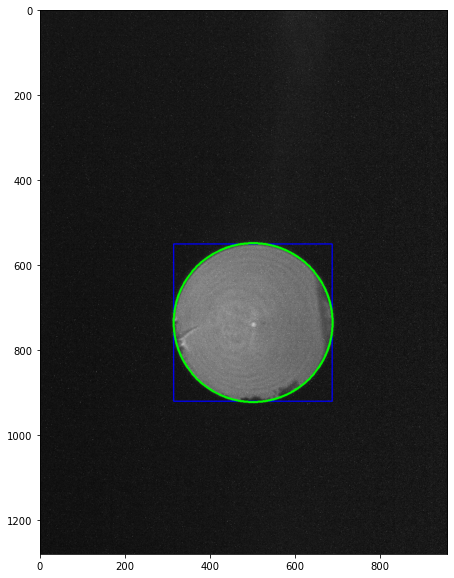

In [223]:
plt.imshow(circle, cmap='gray')

In [130]:
sorted_areas

array([0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
       0.000000e+00, 0.000000e+00, 0.000000e+00, 4.000000e+00,
       4.500000e+00, 5.500000e+00, 5.100000e+01, 9.200000e+01,
       1.049920e+05, 1.226561e+06])

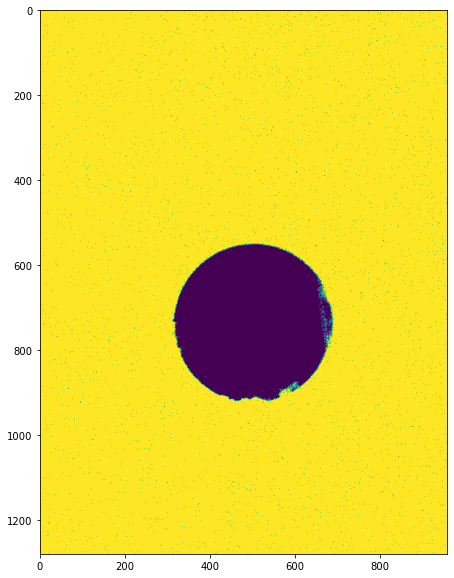

In [125]:
plt.imshow(thresh)